# Project: 'BRFC' - Behavior risk factors & cancer project.





In [59]:
import os
import sqlalchemy
import pandas as pd
from pathlib import Path
import numpy as np 
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

#use provided anaconda environment file: made_project_environment.yml to setup an environment for this file
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Introduction
[//]: # (Introduction: Introduces the problem and motivates your work)



### Motivation

Cancer is one of the leading number of deaths, bronchus and lung cancer deaths are now ranked 6th among the leading causes of deaths (https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death). Also obesity is a world wide health issue and influences diseases. Rising numbers in cancer and obesity are alerting and therefore it is of high interest to reveal any relations of obesity/behavioral risk factors and cancer in order to apply countermeasures.

This project aims to uncover relations of behavioral risk factors and cancer.

The hypothesis for this project:
Behavioural risk factors are influencing the chance to develop cancer.
and
Behavioural risk factors are influencing the chance of mutation(s) in genes which are related to obesity.

### What are behavioural risk factors?
Behavioural risk factors have a strong influence on health and can be:  
- Tocacco use  
- obesity  
- alcohol consumption  
and many more.

For this project the results of a nation wide study in the United States, the 'BRFSS Behavioral Risk Factor Surveillance System' is used. It is run by the Centers for Disease Control and Prevention. Citizens are regulary asked questions in order to collect data for the following statements:  
- Percent of adults aged 18 years and older who have an overweight classification  
- Percent of adults aged 18 years and older who have obesity  
- Percent of adults who engage in muscle-strengthening activities on 2 or more days a week  
- Percent of adults who engage in no leisure-time physical activity  
and more.  
[BRFSS FAQ](https://www.cdc.gov/brfss/about/brfss_faq.htm)

### What is GDC?
This project includes cancer data from the Genomic Data Commons (GDC). This is a reseach program of the National Cancer Institute (NCI) in the United States. GDCs mission is to provide a unified repository to the cancer research community to support research to help all people to live longer, healthier lives.
[GDC - About the GDC](https://gdc.cancer.gov/about-gdc)

## Methods
[//]: # (Methods: Describes which data sources you used and why, how you built your data pipeline and which data cleaning / transformation steps you followed as well as any problems encountered during data engineering)

### Datasources

#### Datasource1 GraphQL API: GDC - NCI Genomic Data Commons
License: Data usage agreement: https://gdc.cancer.gov/about-data/data-analysis-policies  
Data Model: https://gdc.cancer.gov/developers/gdc-data-model  

Cancer and genomic data GraphQL API  
- Metadata URL: https://docs.gdc.cancer.gov/API/Users_Guide/GraphQL_Examples/  
- Data URL: https://api.gdc.cancer.gov/v0/graphql  
- Query: see query in pipeline code (data/gdc1a.py) starting from line 27: [Projects GraphQL query](data/gdc1a.py#L27)  
- Data Type: json  

#### Datasource2 Behavioral Risk Factor Surveillance
License: https://opendefinition.org/licenses/odc-odbl/

Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System  
- Metadata URL: https://catalog.data.gov/harvest/object/721fe106-9250-45d7-9093-1edacb565cd4  
- Data URL: https://catalog.data.gov/dataset/nutrition-physical-activity-and-obesity-behavioral-risk-factor-surveillance-system  
- Data Type: json/xml/rdf/csv  

Centers for Disease Control and Prevention (CDC). Behavioral Risk Factor Surveillance System Survey Data. Atlanta, Georgia: U.S. Department of Health and Human Services, Centers for Disease Control and Prevention, [2023].


### Data pipeline 
#### Datasource1 GraphQL API: GDC
File: [GDC pipeline](data/gdc1a.py)  
Python pipeline to download via GraphQL and store the data into objects.  
One aspect is that GraphQL is a WebAPI which is not downloading the full dataset at one time. A cursor-Based pagination approach is used to get further data until no data is left.
This is implemented in the python pipeline.

#### Datasource2 BRFSS
File: [BRFSS pipeline](data/brfss.jv)  
For this pipeline the domain-specific language and runtime 'Jayvee' is used. It is very easy and straightforward, therefore it was chosen for this pipeline in order to download and store the csv file.  
[Jayvee Project](https://jvalue.github.io/jayvee/)

Both of the pipelines are storing the data into a sqlite database.

#### Transformation
##### Genes
Specific genes are chosen to be of interest in this project. Evaluation on genes contributing to obesity are shown in paper '*Genes contributing to obesity*' [^genes].  
The following genes were checked in the download of the GDC data and if available (=mutated) a variable is set to True in the sink (sqlite) database.  
- SIM1  
- POMC   
- LEPR  
- MRAP2  
- ADCY3  
- NTRK2  
- MC4R  
- KSR2  
- LEP  
- PCSK1  
- BDNF  
- SH2B1  

##### Age in days
GDC data contains the field 'age_at_diagnosis' which represents the age in days. Before saving to the sqlite database it is additionally transformed to a field representing the age in years using the conversion factor 365.25 defined by GDC ([Unit in days](https://docs.gdc.cancer.gov/Data_Portal/Users_Guide/Advanced_Search/#age-at-diagnosis-unit-in-days))
```python
    if (aad):
        aad = round(aad/365.25)
        diagnosis_dict['age_at_diagnosis_years'] = aad
```


### Limitations

#### Data availability in GDC

The data in GDC shows that there are gaps and the cancer data is definitly not complete. This is clear since submitters are not forced to provide the data and only a subset of data is stored at GDC and open to the public.


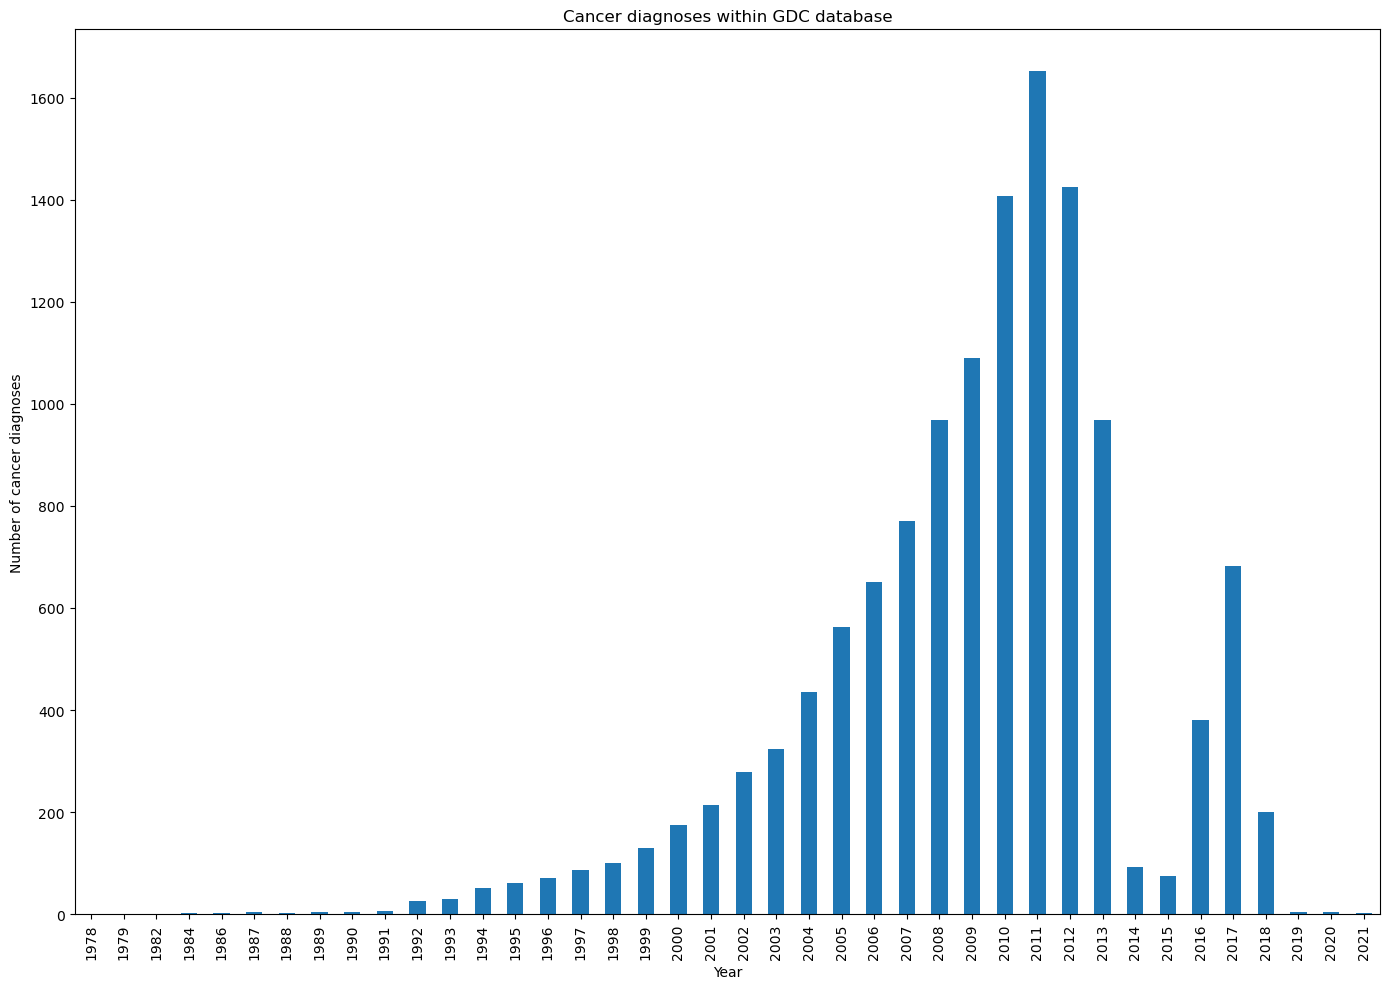

In [42]:
dbEngine=sqlalchemy.create_engine('sqlite:///../data/gdc.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select year_of_diagnosis, count(*) as c from diagnoses where year_of_diagnosis is not null group by year_of_diagnosis"
    gdc = pd.read_sql_query(sqlstatement_obese, conn)
    gdc['year_of_diagnosis'] = gdc['year_of_diagnosis'].astype(int)
    gdc = gdc.set_index('year_of_diagnosis')
ax = gdc['c'].plot(kind='bar')
ax.set(xlabel='Year', ylabel='Number of cancer diagnoses', title='Cancer diagnoses within GDC database');

#### US data in GDC and age at diagnosis

The data in GDC where the country of residence at enrollment of the patient is United States has implications with the age at diagnosis data availability.
The range of age for cancer diagnoses in US are  
- max age 29  
- number aged 18 and older within the gdc data for US = 3  

However the BRFSS data holds data for persons aged 18 and older.

Therefore for this report GDC data is not filtered by 'United States' and opened to all or no definition on country of residence at enrollment with the constraint:  
- the evaluation may not be valid based on the BRFSS data relating to US only  
- Assumption: The inclusion of datasets from different countries will not change the evaluation since the behavioural risk factors can be generalized  

#### Data merge BRFSS and GDC
BRFSS data is available from 2011 to 2022. In the graph above you can see that the data submission for GDC drastically drops in 2014.
Since there is enough data available to support the report, we restrict the evaluation on the year 2011 which is available in both the BRFSS and GDC data source.

### Correlation
The evaluation correlates the data present in year 2011 for all diagnoses and the BRFSS data for the statements:  
- overweight_prob: Percent of adults aged 18 years and older who have an overweight classification  
- obesity_prob: Percent of adults aged 18 years and older who have obesity  
- musclestr2ormore_prob: Percent of adults who engage in muscle-strengthening activities on 2 or more days a week  
- nophyac_prob: Percent of adults who engage in no leisure-time physical activity  

### Classification
In order to support the reports hypothesis, the report asks another question:  
*Can I predict whether there are mutations in any of the obesity related genes, if a person has a cancer diagnosis based on
the following data 'age_at_diagnosis_days', 'primary_site', 'disease_type', 'obesity_prob', 'overweight_prob', 'nophyac_prob', 'musclestr2ormore_prob'?*

A successful classification would help to underline the reports hypothesis which relates BRFSS and cancer data and helps to emphasize the importance on further detailed analysis.

Therefore the Logistic Regression is used in order to classify on a binary outcome telling whether there is a mutation in any of the genes related to obesity or not.

## Results
[//]: # (Results: Presents the data in a fitting format (e.g., tables, diagrams, figures or similar) without interpretation)



### Correlation

The BRFSS data in years 2011 to 2022:

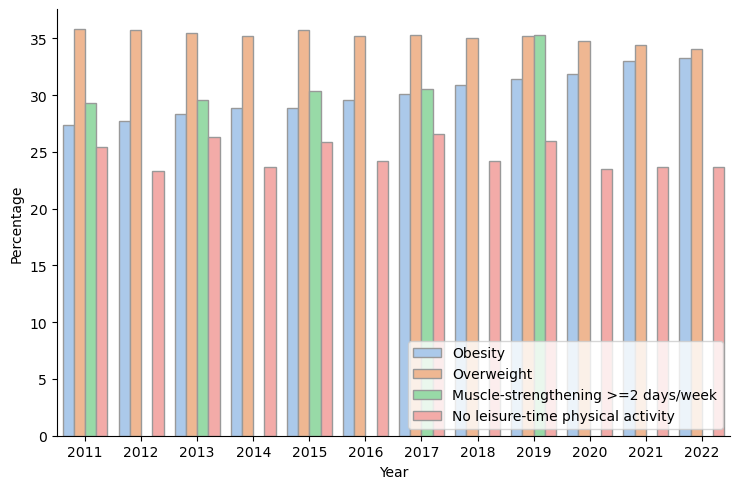

In [43]:
dbEngine=sqlalchemy.create_engine('sqlite:///../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and Total = 'Total' and Question like '%aged 18 years and older who have obesity' order by YearStart"
    brfss_obesity2 = pd.read_sql_query(sqlstatement_obese, conn)
    brfss_obesity2['Data_Value'] = brfss_obesity2['Data_Value'].astype("float")
    brfss_obesity2['Categories of BRFSS'] = 'Obesity'

    sqlstatement_overweight = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and Total = 'Total' and Question like 'Percent of adults aged 18 years and older who have an overweight classification' order by YearStart"
    brfss_overweight = pd.read_sql_query(sqlstatement_overweight, conn)
    brfss_overweight['Data_Value'] = brfss_overweight['Data_Value'].astype("float")
    brfss_overweight['Categories of BRFSS'] = 'Overweight'

    sqlstatement_ms2d = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and Total = 'Total' and Question like 'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week' order by YearStart"
    brfss_ms2d = pd.read_sql_query(sqlstatement_ms2d, conn)
    brfss_ms2d['Data_Value'] = brfss_ms2d['Data_Value'].astype("float")
    brfss_ms2d['Categories of BRFSS'] = 'Muscle-strengthening >=2 days/week'

    sqlstatement_nophyac = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and Total = 'Total' and Question like 'Percent of adults who engage in no leisure-time physical activity' order by YearStart"
    brfss_nophyac = pd.read_sql_query(sqlstatement_nophyac, conn)
    brfss_nophyac['Data_Value'] = brfss_nophyac['Data_Value'].astype("float")
    brfss_nophyac['Categories of BRFSS'] = 'No leisure-time physical activity'

    brfss_cat = pd.concat([brfss_obesity2, brfss_overweight, brfss_ms2d, brfss_nophyac])
    

brfss_plot = sns.catplot(
    data=brfss_cat, x="YearStart", y="Data_Value", hue="Categories of BRFSS", kind="bar",
    palette="pastel", edgecolor=".6", legend=False, height=5, aspect=1.5
)

plt.xlabel("Year")
plt.ylabel("Percentage")
plt.legend(loc='lower right');


GDC data and its increase in entries of genes with mutations. Genes as referred to the selected genes related to obesity, see [Data pipeline-Transformation-Genes](#genes).


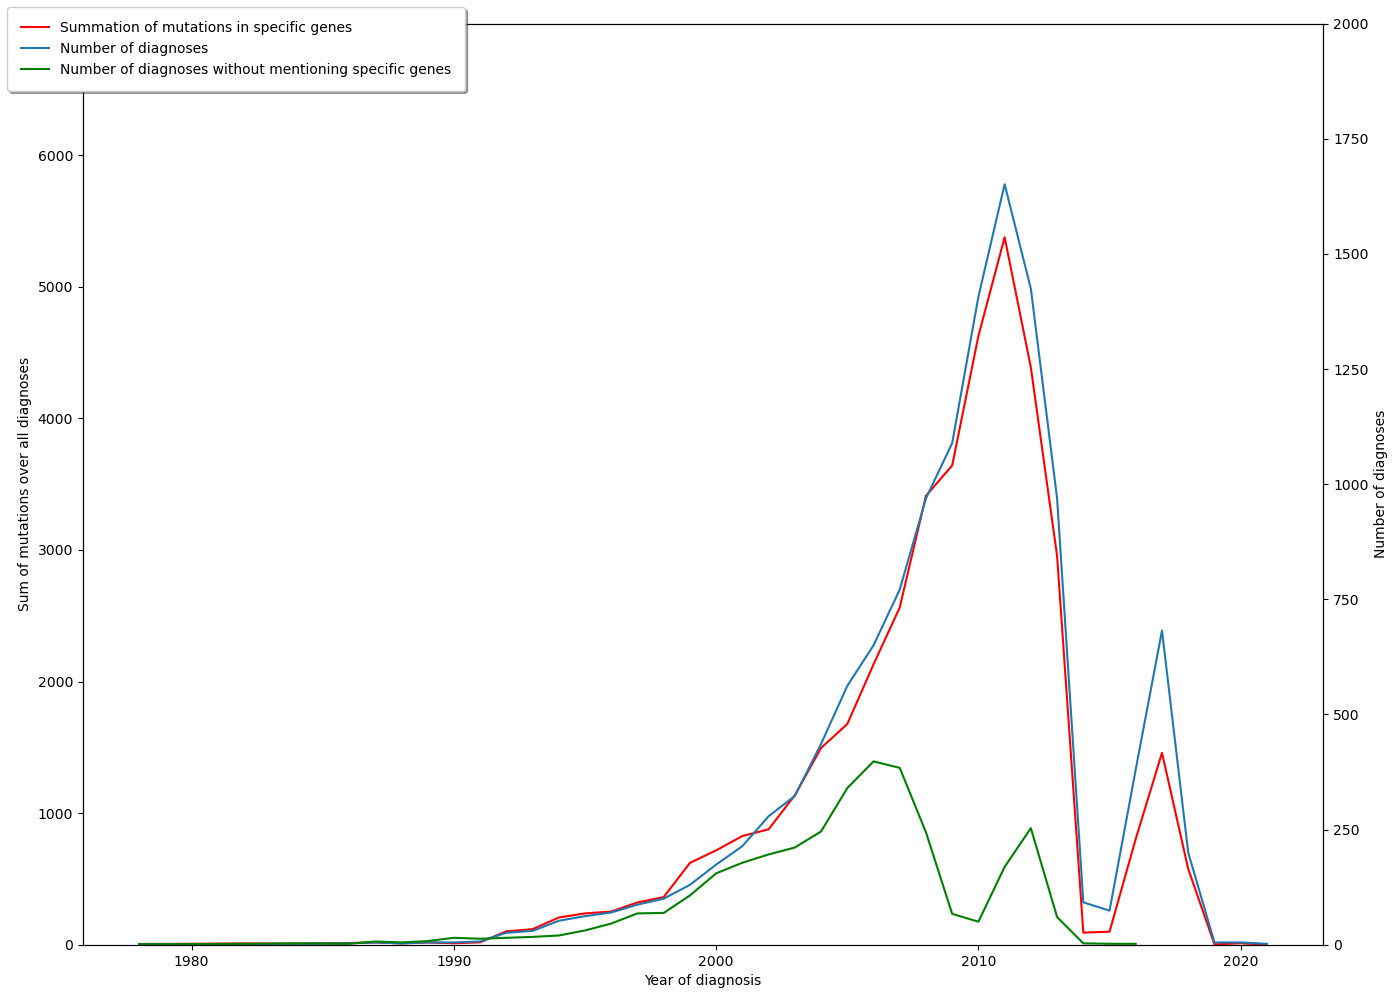

In [60]:
dbEngine=sqlalchemy.create_engine('sqlite:///../data/gdc.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select year_of_diagnosis, count(*) as nrdiag, sum(sim), sum(p), sum(lpr), sum(mr), sum(a), sum(n), sum(m), sum(k), sum(l), sum(pc), sum(b), sum(s), sum(sim)+sum(p)+sum(lpr)+sum(mr)+sum(a)+sum(n)+sum(m)+sum(k)+sum(l)+sum(pc)+sum(b)+sum(s) as gene_sum, (sum(sim)+sum(p)+sum(lpr)+sum(mr)+sum(a)+sum(n)+sum(m)+sum(k)+sum(l)+sum(pc)+sum(b)+sum(s))/count(*) as gene_sum_per_nrdiag from (select d.year_of_diagnosis, c.\"gene.SIM1\" as sim, c.\"gene.POMC\" as p, c.\"gene.LEPR\" as lpr, c.\"gene.MRAP2\" as mr, c.\"gene.ADCY3\" as a, c.\"gene.NTRK2\" as n, c.\"gene.MC4R\" as m, c.\"gene.KSR2\" as k, c.\"gene.LEP\" as l, c.\"gene.PCSK1\" as pc, c.\"gene.BDNF\" as b, c.\"gene.SH2B1\" as s from cases c, diagnoses d where c.id = d.case_id and year_of_diagnosis is not null) group by year_of_diagnosis ;"
    gdc = pd.read_sql_query(sqlstatement_obese, conn)
    gdc['year_of_diagnosis'] = gdc['year_of_diagnosis'].astype(int)
    gdc_woGene = pd.read_sql_query('select year_of_diagnosis, count(*) as nrdiag from (select d.year_of_diagnosis, c."gene.SIM1"+c."gene.POMC"+c."gene.LEPR"+c."gene.MRAP2"+c."gene.ADCY3"+c."gene.NTRK2"+c."gene.MC4R"+c."gene.KSR2"+c."gene.LEP"+c."gene.PCSK1"+c."gene.BDNF"+c."gene.SH2B1" as gene_sum from cases c, diagnoses d where c.id = d.case_id and year_of_diagnosis is not null) where gene_sum = 0 group by year_of_diagnosis;', conn)
    gdc_woGene['year_of_diagnosis'] = gdc['year_of_diagnosis'].astype(int)

fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.lineplot(x='year_of_diagnosis', y='nrdiag', data=gdc, ax=ax2, label='Number of diagnoses', legend=False)
sns.lineplot(x='year_of_diagnosis', y='nrdiag', data=gdc_woGene, ax=ax2, color='green', label='Number of diagnoses without mentioning specific genes', legend=False)
legax2 = plt.legend()
sns.lineplot(x='year_of_diagnosis', y='gene_sum', data=gdc, ax=ax, color='r', label='Summation of mutations in specific genes', legend=False)
legax = plt.legend()
legax2.remove()
legax.remove()
ax2.set_ylim(0, 2000)
ax.set_ylim(0, 7000)
ax.set(xlabel='Year of diagnosis', ylabel = 'Sum of mutations over all diagnoses')
ax2.set(ylabel='Number of diagnoses')

plt.figlegend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

In the graph there is a relation of mutation in genes (red) to the number of diagnoses (blue), however, there are diagnoses without mentioning any gene mutations at all (green) which are included in the overal number of diagnoses (blue). 
For many other assumptions in this report here also applies that the submissions to GDC are on a free basis and that means there is no statement about the completeness of the data whether the diagnoses are incomplete (missing genes) or there are no mutations.



In [45]:
dbEngine=sqlalchemy.create_engine('sqlite:///../data/gdc.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_obese = "select d.*, c.*,\
  case\
   when age_at_diagnosis_years <18 then 'Under 18'\
   when age_at_diagnosis_years between 18 and 24 then '18 - 24'\
   when age_at_diagnosis_years between 25 and 34 then '25 - 34'\
   when age_at_diagnosis_years between 35 and 44 then '35 - 44'\
   when age_at_diagnosis_years between 45 and 54 then '45 - 54'\
   when age_at_diagnosis_years between 55 and 64 then '55 - 64'\
   when age_at_diagnosis_years >= 65 then '65 or older'\
 END as age_range,\
 CASE \
 	when c.\"gene.SIM1\" = '1' or c.\"gene.POMC\" = 1 or c.\"gene.LEPR\" ='1' or c.\"gene.MRAP2\" = 1 or c.\"gene.ADCY3\" = 1 or c.\"gene.NTRK2\" = 1 or c.\"gene.MC4R\"  = 1 or c.\"gene.KSR2\" = 1 or c.\"gene.LEP\" = 1 or c.\"gene.PCSK1\" = 1 or c.\"gene.BDNF\"  =1 or c.\"gene.SH2B1\" = 1 then TRUE \
 	ELSE FALSE \
 END as obesity_mutation,\
 (c.\"gene.SIM1\" + c.\"gene.POMC\" + c.\"gene.LEPR\" + c.\"gene.MRAP2\" + c.\"gene.ADCY3\" + c.\"gene.NTRK2\" + c.\"gene.MC4R\" + c.\"gene.KSR2\" + c.\"gene.LEP\" + c.\"gene.PCSK1\" + c.\"gene.BDNF\" + c.\"gene.SH2B1\") as obesity_mutation_count\
 from diagnoses d, cases c\
 where d.case_id = c.id  and year_of_diagnosis = '2011' and year_of_diagnosis is not null;"
    gdc = pd.read_sql_query(sqlstatement_obese, conn)
    gdc['year_of_diagnosis'] = gdc['year_of_diagnosis'].astype(int)

dbEngine=sqlalchemy.create_engine('sqlite:///../data/brfss.sqlite')
with dbEngine.connect() as conn:
    sqlstatement_musclestr2ormore = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week' and YearStart = 2011 order by StratificationID1;"
    brfss_musclestr2ormore = pd.read_sql_query(sqlstatement_musclestr2ormore, conn)
    brfss_musclestr2ormore['Data_Value'] = brfss_musclestr2ormore['Data_Value'].astype("float")
    
    sqlstatement_nophyac = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults who engage in no leisure-time physical activity' and YearStart = 2011 order by StratificationID1;"
    brfss_nophyac = pd.read_sql_query(sqlstatement_nophyac, conn)
    brfss_nophyac['Data_Value'] = brfss_nophyac['Data_Value'].astype("float")

    sqlstatement_overweight = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like 'Percent of adults aged 18 years and older who have an overweight classification' and YearStart = 2011 order by StratificationID1;"
    brfss_overweight = pd.read_sql_query(sqlstatement_overweight, conn)
    brfss_overweight['Data_Value'] = brfss_overweight['Data_Value'].astype("float")

    sqlstatement_obese = "select YearStart, Data_Value, \"Age(years)\"  from brfss where LocationDesc = 'National' and length(\"Age(years)\") > 0 and Question like '%aged 18 years and older who have obesity' and YearStart = 2011 order by StratificationID1;"
    brfss_obesity = pd.read_sql_query(sqlstatement_obese, conn)
    brfss_obesity['Data_Value'] = brfss_obesity['Data_Value'].astype("float")
    
brfss_gdc = gdc

def obesity_prob(age_group):
    ob_lines = brfss_obesity.loc[brfss_obesity['Age(years)'] == age_group]
    ob_line = ob_lines.iloc[0]
    return ob_line['Data_Value']

def overweight_prob(age_group):
    lines = brfss_overweight.loc[brfss_overweight['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

def nophyac_prob(age_group):
    lines = brfss_nophyac.loc[brfss_nophyac['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

def musclestr2ormore_prob(age_group):
    lines = brfss_musclestr2ormore.loc[brfss_musclestr2ormore['Age(years)'] == age_group]
    line = lines.iloc[0]
    return line['Data_Value']

brfss_gdc['obesity_prob'] = brfss_gdc['age_range'].map(obesity_prob)
brfss_gdc['overweight_prob'] = brfss_gdc['age_range'].map(overweight_prob)
brfss_gdc['nophyac_prob'] = brfss_gdc['age_range'].map(nophyac_prob)
brfss_gdc['musclestr2ormore_prob'] = brfss_gdc['age_range'].map(musclestr2ormore_prob)

Next graph shows the amount of changes in the specific genes in each age group. Since BRFSS data contains age groups, we relate the two datasets with those groups.

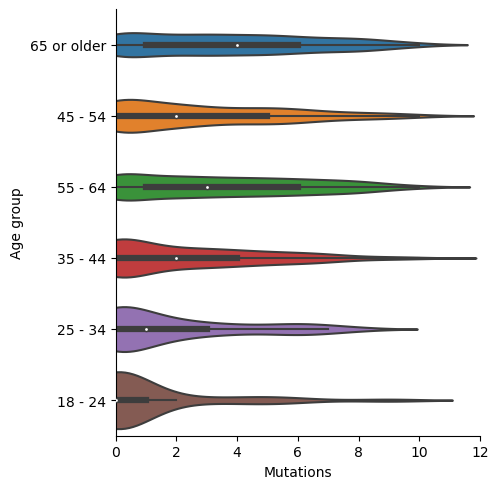

In [48]:
f=sns.catplot(data=brfss_gdc, x='obesity_mutation_count', y='age_range', kind='violin')
plt.xlabel("Mutations")
plt.ylabel("Age group")
f.set(xlim=(0,12));

The graph shows that as older the patients are the more the mutations occur in the genes related to obesity.

Next, we have a look at the correlation matrix for the following attributes:  
- age_at_diagnosis_days: Age at diagnosis (days)  
- obesity_prob: Probability of obesity  
- overweight_prob: Probability of overweight  
- nophyac_prob: Probability of no physical activity  
- musclestr2ormore_prob: Probability of muscle strengthening 2 or more days a week  
- obesity_mutation: Mutations in genes related to obesity (y/n)  
- obesity_mutation_count: Number of mutations in genes related to obesity  


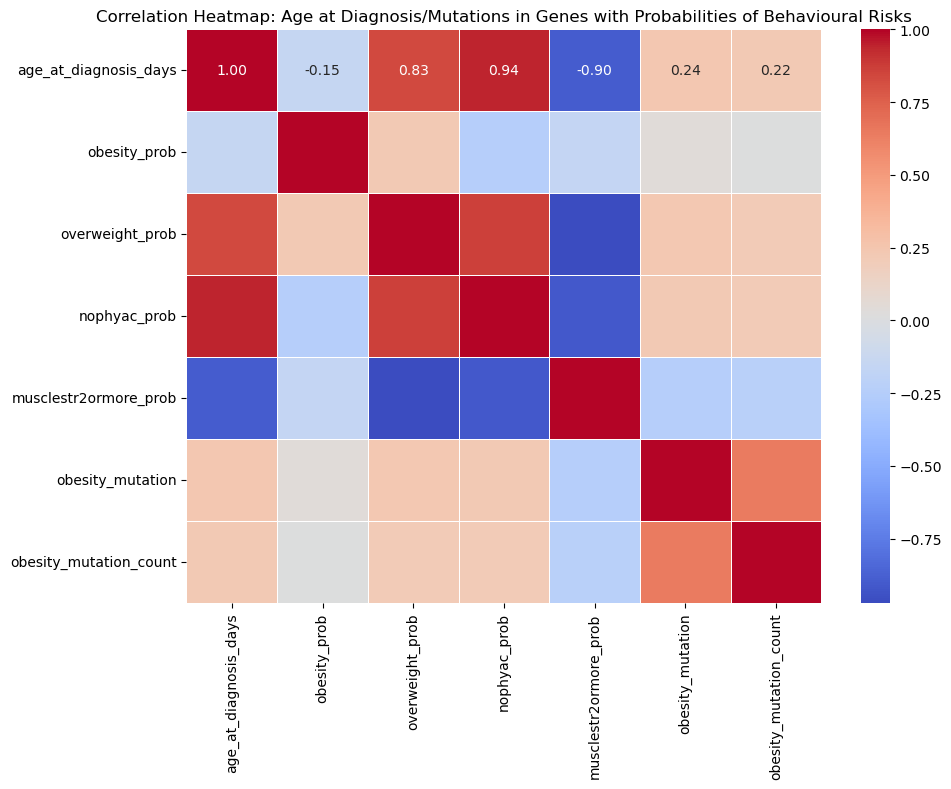

In [57]:
xdf = pd.DataFrame(brfss_gdc, columns=['age_at_diagnosis_days', 'obesity_prob', 'overweight_prob', 'nophyac_prob', 'musclestr2ormore_prob', 'obesity_mutation', 'obesity_mutation_count'])

correlation_df = xdf
correlation_matrix = correlation_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap: Age at Diagnosis/Mutations in Genes with Probabilities of Behavioural Risks')
plt.show()

The correlation matrix shows correlation between:  
Age at diagnosis and    
    - Probability of overweight (0.83)   
    - Probability of no physical activity (0.94)  
    - Probability of muscle strengthening 2 or more days a week (-0.90)  
Other combination do not show significant correlation.

### Classification

For the classification, the logistic regression is used to classify if there is a mutation in one or more genes related to obesity or not. So, it is a binary classification and the logistic regression is a perfect fit.



In [55]:
xdf = pd.DataFrame(brfss_gdc, columns=['age_at_diagnosis_days', 'primary_site', 'disease_type', 'obesity_prob', 'overweight_prob', 'nophyac_prob', 'musclestr2ormore_prob'])

def onehotEncoding(orig, feature):
    one_hot = pd.get_dummies(xdf[[feature]])
    res = pd.concat([xdf, one_hot], axis=1)
    return(res)

xdf = onehotEncoding(xdf, 'primary_site')
xdf = onehotEncoding(xdf, 'disease_type')
xdf.pop('primary_site')
xdf.pop('disease_type');

y = brfss_gdc['obesity_mutation']

x_train, x_temp, y_train, y_temp = train_test_split(xdf, y, random_state=42, train_size=.7, test_size=.3)
x_validation, x_test, y_validation, y_test = train_test_split(x_temp, y_temp, random_state=42, train_size=2/3, test_size=1/3)

#Logistic regression
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(x_train, y_train);

#Validation
prediction = logreg.predict(x_validation)

##Classification Report
print(classification_report(y_validation, prediction))

              precision    recall  f1-score   support

           0       0.90      0.47      0.62        81
           1       0.85      0.98      0.91       249

    accuracy                           0.86       330
   macro avg       0.88      0.73      0.77       330
weighted avg       0.86      0.86      0.84       330



The validation of the logistic regression shows the precision, recall and f1-score of the classification for  
- 0: no mutation  
- 1: mutation in one or more genes related to obesity  
The sampling size is 81 for class=0 and 249 for class=1, so a validation set of size 330. 
We splitted the data into a training set (1155 diagnoses), a validation set (330 diagnoses) and a test set(166 diagnoses).

The training set is used to train the logistic regression function, the validation set is used to validate the predictions and the test set is kept away from the training phase in order to prevent overfitting.  
The test set would come into play when a model selection would occur. Since there is only one model in the report the test set is not used.

Further validation of the logistic regression is done by providing the Receiver-Operator-Curve and the Area-Under-Curve value:  

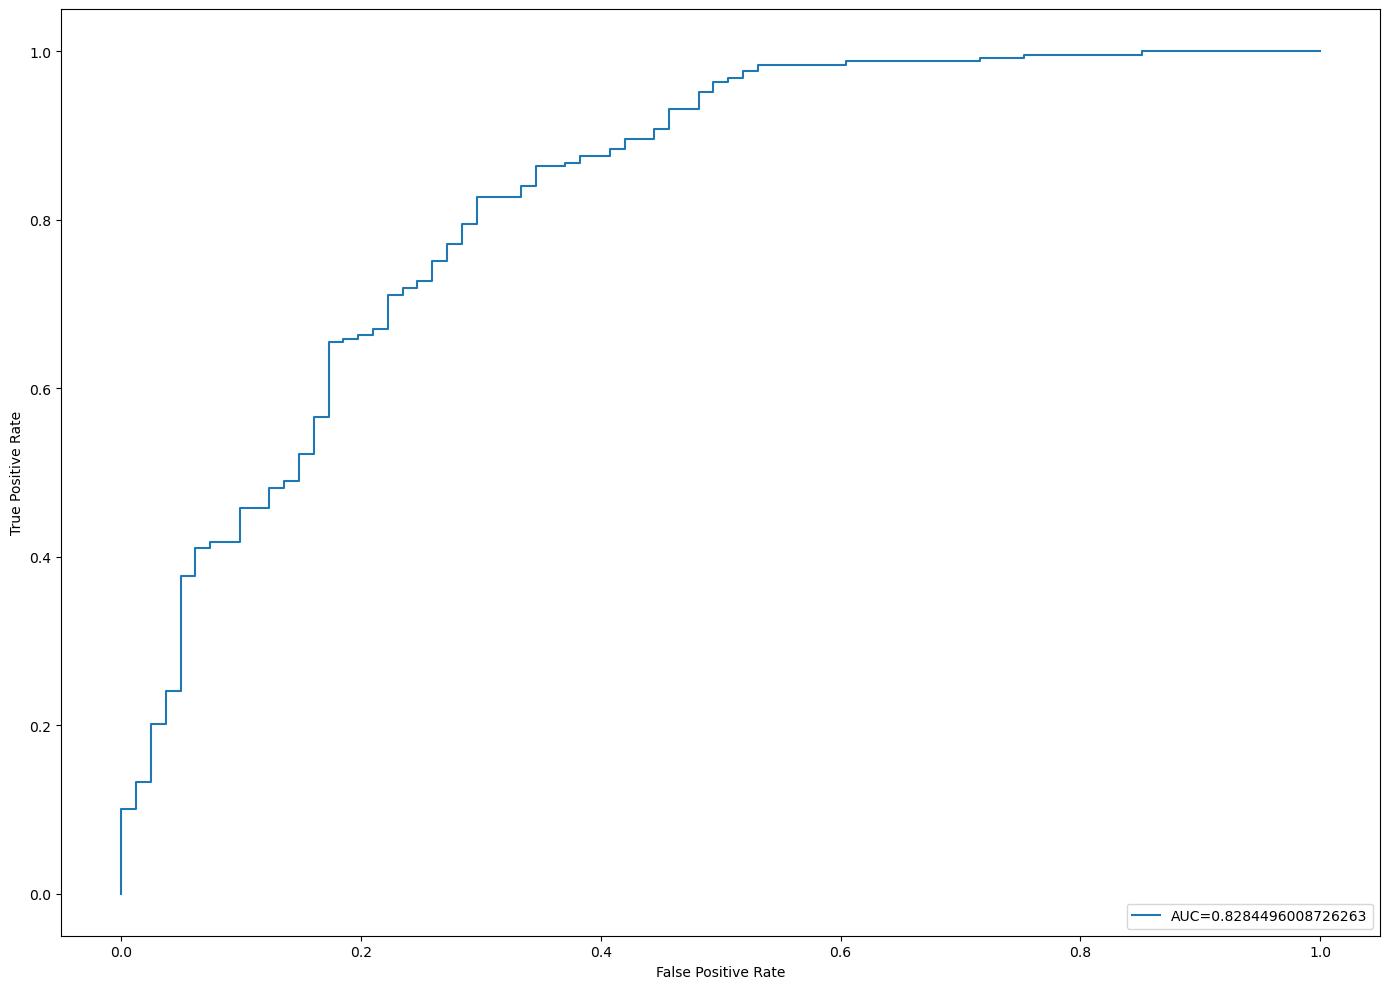

In [56]:
##ROC and AUC
y_pred_proba = logreg.predict_proba(x_validation)[::,1]
fpr, tpr, _ = roc_curve(y_validation,  y_pred_proba)
auc = roc_auc_score(y_validation, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Discussion and Conclusions
[//]: # (Discussion/Conclusions: Your interpretation of the results, any limitations you can see and (optionally) an outlook to future work)

Limitations on the GDC data caused that only the year 2011 is included into the report due to no completeness on cancer data delivered to GDC and not enough years overlapping in both datasets. 

Even though the GDC Datasource has a field for exposure weight or BMI, it is not filled in any of their datasets. Therefore, it is not possible to link the obesity numbers of BRFSS dataset to the cancer in general. 

The BRFSS data is gathered from citizens in the United States. In contrast to the GDC dataset where diagnoses are linked to different countries (united states, canada, ...). Since a lot of data sets in GDC are without any specification on that field (country of residence at enrollment), for reasons of ease for this project the cases from GDC are not restricted to United States.

With these limitations, the report can show that there may be correlation between behavioural risk factors (overweight, no physical activity and muscle strengthening 2 or more days a week) and the age at the diagnosis of the cancer.

The correlation matrix shows that there can be a classification task which could potentially be successful.

The logistic regression is trained and reveals good validation metrics.

The classification report for the logistic regression indicates a good precision for both classes which means that the classification can identify positive predictions on both classes quite well (the number of wrong classified cases in the classes is low - small number in False Positives).

The recall and then also the F1-score drops for classifying no mutations (class=0) which means that the classification is not very sensitive towards classifying diagnoses without any mutations. Hence, there will be more False Negatives for the class 0 which means there will be an amount of diagnoses which are classified as class 1 but are class 0 (some False Negatives for class=0).

This means that we tend to classify more towards class 1 which would be ok for further investigation since it will just include more cases to investigate the mutations in genes.

The Receiver-Operator-Curve ROC shows that we have a result which is ok. It is definitly better than random (diagonal). The Area-Under-Curve is around 0.83 which is also close to 1. The closer it is to 1 the better the specificity and sensitivity of the classifier.

This could be used to investigate on more classifiers by compareing the validation results, deciding on a classifier and running a test with the test data (kept away from train-validation cycle).

In overal, all the results have to be used with care and caution since cancer is influenced by many things, not only behavioural risk factors. Thus, this report can only be a direction for further investigations on this topic.

#### Outlook

The result in this report shows that mutations in genes related to obesity for patients with a cancer diagnosis could potentially be linked to the behavioural risk factors. On a next step, it would be very interesting to connect obesity identifying data (BMI) to cancer data on a case basis.

Futhermore, changes in genes can be harmful but can also be without or with low consequences. Therefore a deeper evaluation on the impact of the DNA changes of the obesity related genes would be beneficial. This data is also available in GDC.

The submissions are not forced for GDC. In Germany there is a law for delivering cancer related data, however, it only contains a very limited subset of information which GDC is providing. 
I would highly recommend the possibility in the future to either add obesity identifying data (like BMI) to cancer data or to make it possible to connect datasets (like in other studies, e.g. NAKO - Nationale Gesundheitsstudie, which is not open data).

## References

[^genes]: Genes contributing to obesity [The genetics of obesity: from discovery to biology](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8459824/)
Loos RJF, Yeo GSH. The genetics of obesity: from discovery to biology. Nat Rev Genet. 2022 Feb;23(2):120-133. doi: 10.1038/s41576-021-00414-z. Epub 2021 Sep 23. PMID: 34556834; PMCID: PMC8459824.